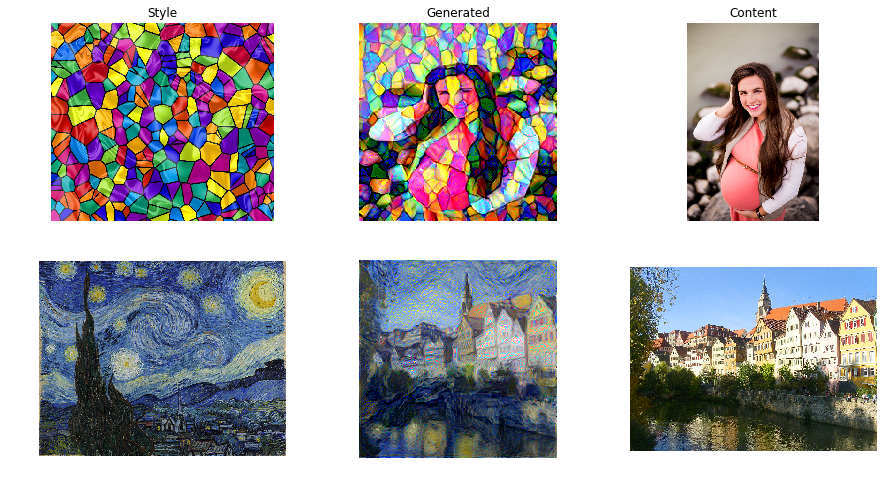

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

content_img = plt.imread('content.jpg')
style_img = plt.imread('style.jpg')
gen_img = plt.imread('stylized_image.png')
content_img2 = plt.imread('original_ims/content.png')
style_img2 = plt.imread('original_ims/style.png')
gen_img2 = plt.imread('original_ims/stylized_image.png')

fig = plt.figure(num=1, figsize=(15,8))
ax1 = fig.add_subplot(231)
ax1.imshow(style_img)
ax1.set_title('Style')
plt.axis('off')
ax2 = fig.add_subplot(232)
ax2.imshow(gen_img)
ax2.set_title('Generated')
plt.axis('off')
ax3 = fig.add_subplot(233)
ax3.imshow(content_img)
ax3.set_title('Content')
plt.axis('off')
ax4 = fig.add_subplot(234)
ax4.imshow(style_img2)
plt.axis('off')
ax5 = fig.add_subplot(235)
ax5.imshow(gen_img2)
plt.axis('off')
ax6 = fig.add_subplot(236)
ax6.imshow(content_img2)
plt.axis('off')
plt.show()

In [ ]:
# Here is my code
import numpy as np
import tensorflow as tf
import vgg16
from scipy.misc import imread, imresize, imsave
from pdb import set_trace as stop

sess = tf.Session()

opt_img = tf.Variable( tf.truncated_normal( [1,224,224,3],
                                        dtype=tf.float32,
                                        stddev=1e-1), name='opt_img' )

tmp_img = tf.clip_by_value( opt_img, 0.0, 255.0 )

vgg = vgg16.vgg16( tmp_img, 'vgg16_weights.npz', sess )

# style_img = imread( 'style.png', mode='RGB' )
style_img = imread( 'style.jpg', mode='RGB' )
style_img = imresize( style_img, (224, 224) )
style_img = np.reshape( style_img, [1,224,224,3] )

# content_img = imread( 'content.png', mode='RGB' )
content_img = imread( 'content.jpg', mode='RGB' )
content_img = imresize( content_img, (224, 224) )
content_img = np.reshape( content_img, [1,224,224,3] )

layers = [ 'conv1_1', 'conv1_2',
           'conv2_1', 'conv2_2',
           'conv3_1', 'conv3_2', 'conv3_3',
           'conv4_1', 'conv4_2', 'conv4_3',
           'conv5_1', 'conv5_2', 'conv5_3' ]

ops = [ getattr( vgg, x ) for x in layers ]

content_acts = sess.run( ops, feed_dict={vgg.imgs: content_img } )
style_acts = sess.run( ops, feed_dict={vgg.imgs: style_img} )

#
# --- construct your cost function here ---------------------------------------------------------------
#

# Relevant snippets from the paper:
#   For the images shown in Fig 2 we matched the content representation on layer 'conv4_2'
#   and the style representations on layers 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1' and 'conv5_1'
#   The ratio alpha/beta was  1x10-3
#   The factor w_l was always equal to one divided by the number of active layers (ie, 1/5)

# Content Loss
P = tf.squeeze(content_acts[7])
F = tf.squeeze(vgg.conv4_1)
L_content = 0.5*tf.reduce_sum(tf.pow(F - P, 2.0))

# Style Loss
style_layers = [0, 2, 4, 7, 10]
content_layers = [vgg.conv1_1, vgg.conv2_1, vgg.conv3_1, vgg.conv4_1, vgg.conv5_1]
El = []
N = len(style_layers)
w = [1.0/N] * N
for i in xrange(len(style_layers)):
    shape = np.shape(style_acts[style_layers[i]]) # find the shape of the ith filter bank
    N = shape[-1]
    M = shape[1]**2
    G = tf.reshape(tf.squeeze(content_layers[i]),(-1,N))
    A = tf.reshape(tf.squeeze(style_acts[style_layers[i]]),(-1,N))
    G = tf.matmul(tf.transpose(G), G)
    A = tf.matmul(tf.transpose(A), A)
    El.append((1.0/(4.0*N**2 * M**2))*tf.reduce_sum(tf.pow(G - A, 2)))
L_style = tf.reduce_sum(tf.multiply(w,El))

# Total Loss
alpha = 1
beta = 1.e3
L_total = alpha*L_content + beta*L_style

# --- place your adam optimizer call here
#     (don't forget to optimize only the opt_img variable)
optimize = tf.train.AdamOptimizer(0.1).minimize(L_total, var_list = [opt_img])

# this clobbers all VGG variables, but we need it to initialize the
# adam stuff, so we reload all of the weights...
sess.run( tf.global_variables_initializer() )
vgg.load_weights( 'vgg16_weights.npz', sess )

# initialize with the content image
sess.run( opt_img.assign( content_img ))

# --- place your optimization loop here
num_iterations = 6000
writer = tf.summary.FileWriter('./tf_logs', sess.graph)
tf.summary.image('gen_im', opt_img)
tf.summary.scalar('L_total', L_total)
tf.summary.scalar('L_content', L_content)
tf.summary.scalar('L_style', L_style)
merged = tf.summary.merge_all()

for i in xrange(num_iterations):
    [otim, loss_c, loss_s, loss_t, ss, img] = sess.run([optimize, L_content, L_style, L_total, merged, opt_img])
    if i % 100 == 0:
        print 'Iteration %r \t Loss %r \t Style Loss %r \t Content Loss %r' % (i, loss_t, loss_s, loss_c)
        imsave('stylized_image.png', np.squeeze(img, axis=0))
    writer.add_summary(ss,i)


imsave('stylized_image.png', np.squeeze(img, axis=0))
writer.close()